In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
torch.manual_seed(42)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# === 1. Generate more expressive sine-like data ===
train_data_length = 1024
x_vals = 2.0 * math.pi * torch.rand(train_data_length)
y_vals = torch.sin(x_vals)

train_data = torch.stack((x_vals, y_vals), dim=1)
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# === 2. Discriminator (same as yours) ===
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# === 3. Generator: maps x + noise → y ===
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)  # Output y
        )

    def forward(self, x):  # x shape: (batch_size, 2)
        return self.model(x)

# === 4. Initialize ===
discriminator = Discriminator()
generator = Generator()
loss_function = nn.BCELoss()
lr = 0.0005
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)
optimizer_g = optim.Adam(generator.parameters(), lr=lr)

# === 5. Training loop ===
num_epochs = 7000
batch_size = 64

for epoch in range(num_epochs):
    for real_samples, _ in train_loader:
        real_labels = torch.ones((batch_size, 1)) * (0.8 + 0.2 * torch.rand((batch_size, 1)))
        fake_labels = torch.zeros((batch_size, 1))

        # === Train Discriminator ===
        # Real samples
        d_real_input = real_samples
        d_real_output = discriminator(d_real_input)

        # Fake samples
        x_noise = torch.rand((batch_size, 1)) * 2 * math.pi  # x ∈ [0, 2π]
        z_noise = torch.randn((batch_size, 1)) * 0.1          # small noise
        gen_input = torch.cat((x_noise, z_noise), dim=1)
        y_gen = generator(gen_input)
        d_fake_input = torch.cat((x_noise, y_gen), dim=1)
        d_fake_output = discriminator(d_fake_input.detach())

        d_all_outputs = torch.cat((d_real_output, d_fake_output), dim=0)
        d_all_labels = torch.cat((real_labels, fake_labels), dim=0)

        discriminator.zero_grad()
        d_loss = loss_function(d_all_outputs, d_all_labels)
        d_loss.backward()
        optimizer_d.step()

        # === Train Generator ===
        x_noise = torch.rand((batch_size, 1)) * 2 * math.pi
        z_noise = torch.randn((batch_size, 1)) * 0.1
        gen_input = torch.cat((x_noise, z_noise), dim=1)
        y_gen = generator(gen_input)
        d_fake_input = torch.cat((x_noise, y_gen), dim=1)
        g_output = discriminator(d_fake_input)

        generator.zero_grad()
        g_loss = loss_function(g_output, real_labels)
        g_loss.backward()
        optimizer_g.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")





Epoch 0 | D Loss: 0.6747 | G Loss: 0.7462
Epoch 1000 | D Loss: 0.6902 | G Loss: 0.7817
Epoch 2000 | D Loss: 0.6921 | G Loss: 0.7934
Epoch 3000 | D Loss: 0.6876 | G Loss: 0.8419
Epoch 4000 | D Loss: 0.6317 | G Loss: 1.2904
Epoch 5000 | D Loss: 0.6827 | G Loss: 0.8640
Epoch 6000 | D Loss: 0.6557 | G Loss: 0.8781


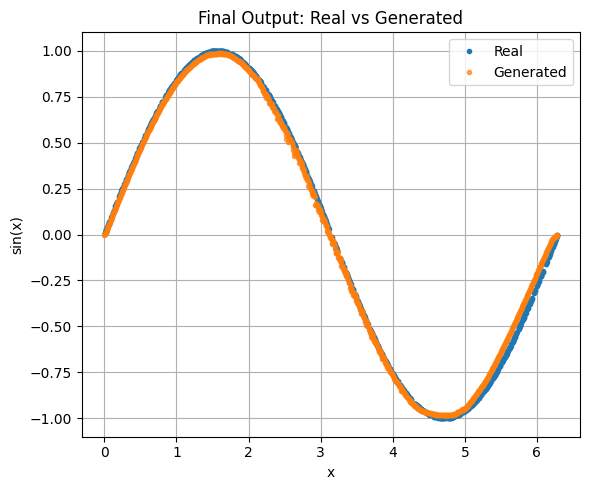

In [13]:
with torch.no_grad():
    x_test = torch.linspace(0, 2 * math.pi, 1000).reshape(-1, 1)
    z_test = torch.randn_like(x_test) * 0.1
    gen_input = torch.cat((x_test, z_test), dim=1)
    y_gen = generator(gen_input)

    generated = torch.cat((x_test, y_gen), dim=1).numpy()  # Shape: (1000, 2)

# Sort real data
sorted_idx = x_vals.argsort()
x_sorted = x_vals[sorted_idx]
y_sorted = y_vals[sorted_idx]

# Plot
plt.figure(figsize=(6, 5))
plt.plot(x_sorted, y_sorted, '.', label="Real", color="#1f77b4")  # Blue
plt.plot(generated[:, 0], generated[:, 1], '.', alpha=0.7, label="Generated", color="#ff7f0e")  # Orange
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Final Output: Real vs Generated")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("final_sine_gan_plot.png", dpi=300)
plt.show()
